# Model 1
## Dataset:

## Programmer: Giovanni Vecchione
## Date: 4/4/24
## Subject: Machine Learning 2 - Project 4
Use Recurrent Neural Networks(RNN)/LSTM/GRU or sentiment analysis to build the project. 
Submit your project as Jupyter notebook

Goal: RNN model that can detect emotion from text

Dataset: tweet_emotions.csv from kaggle
https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text/data 

In [741]:
import tensorflow as tf
import random
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 


from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

from keras.preprocessing.sequence import pad_sequences 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

seed = 42
random.seed(seed)

In [742]:
#Checks if GPU is being used
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("Using GPU:", torch.cuda.get_device_name(0)) 
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("GPU not available, using CPU.")

#Using GPU: NVIDIA GeForce GTX 1660 SUPER - Successful
#NOTE: This took some time to set up by installing and pathing the cuda toolkit v.12.4 and the right supplemental packages. This drastically improved
#training time

Using GPU: NVIDIA GeForce GTX 1660 SUPER


In [743]:
# Load the CSV into a pandas DataFrame
#change path if needed. In my case after extracting I have to state the csv file twice for some reason.
data = pd.read_csv(r'D:\GioDude\Documents\ACC\Spring 2024\Machine Learning II\Datasets\tweet_emotions_data\tweet_emotions.csv\tweet_emotions.csv')

# Check out the data
print(data.head())  # Print the first few rows to see its structure
print(data.shape)   # See dimensions: (number of rows, number of columns)

     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...
(40000, 3)


In [744]:
# Drop rows with missing 'content'
data.dropna(subset=['content'], inplace=True) 

# Drop rows with missing 'sentiment'
data.dropna(subset=['sentiment'], inplace=True) 

In [745]:
# Check out the data
print(data.head())  # Print the first few rows to see its structure
print(data.shape)   # See dimensions: (number of rows, number of columns)
print(data.isnull().sum())  # Should show zero missing values in 'content' and 'sentiment' 

     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...
(40000, 3)
tweet_id     0
sentiment    0
content      0
dtype: int64


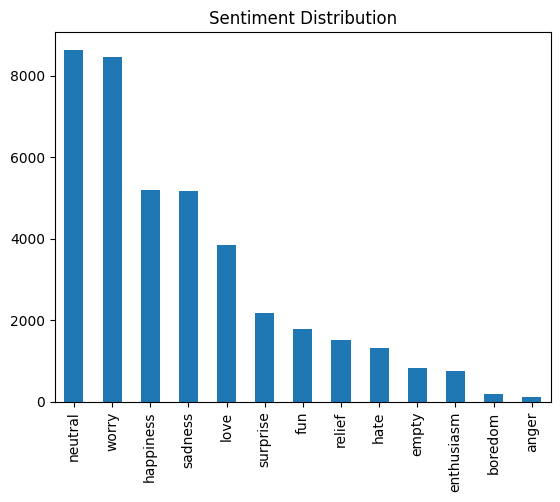

In [746]:
# Sentiment distribution
data['sentiment'].value_counts().plot(kind='bar') 
plt.title('Sentiment Distribution')
plt.show()

Clearly the data above is severely imbalanced and needs to be improved. First I will reduce the first two classes to below 6000 cases and increawse any below the 2000 mark to be at least 2000 cases. This can help with some of the imbalancing.

### NOTE: Rebalance AFTER you split the data to prevent leakage.

# ! Essential Preprocessing Steps (This is for word-level preprocessing)

### 1. Tokenization

Goal: Break down sentences ('content') into meaningful units, usually words.
Libraries: NLTK (Natural Language Toolkit) is a good starting point.

ex. #Tokenization
import nltk
nltk.download('punkt')  # Download tokenizer

def tokenize_text(text):
    sentences = nltk.sent_tokenize(text)  # Split into sentences if needed
    tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences] 
    return tokenized_sentences

 Apply to 'content' column:
data['content'] = data['content'].apply(tokenize_text)

### 2. Building a Vocabulary

Goal: Create a mapping from words to unique numerical indices.
Why? RNNs work best with numerical data.

ex.
from collections import Counter

def build_vocabulary(all_tokens):
    all_words = [word for tokens in all_tokens for word in tokens]
    word_counts = Counter(all_words) 
    vocab = {word: i for i, (word, count) in enumerate(word_counts.most_common())}
    return vocab

### 3. Encoding Sequences

Goal: Turn tokenized text into numerical sequences based on your vocabulary.

ex. 
#Encoding Sequences
#This encoding specifically will address unknown words not in the vocabulary. Great for dynamic datasets and new updated words. 
#### NOTE: Dynamic handling may have issues when using pre-trained models, however in my case I am not using pre-trained models.

def encode_sequences(tokenized_text, vocab):
    unk_token = "<UNK>"
    encoded = []
    for tokens in tokenized_text:
        encoded.append([vocab.get(word, vocab[unk_token]) for word in tokens])  
    return encoded

### 4. Padding

Goal: Make all sequences the same length, RNNs like this.
Technique: Add a special 'PAD' token to shorter sequences.

# (CHANGES) Going with Character-level pre processing

1. Simplification of Preprocessing

No Need for Explicit Tokenization: Character-level models don't need sentence or word tokenization.
Keep:
Case normalization (lowercase)
Basic punctuation removal (if you decide it helps)
Skip:
Contraction expansion (won't be as necessary)
Advanced tokenization like lemmatization.

2. Encode as characters function

3. Building char_to_index function instead of a vocabulary.

4. Padding (same as before)

In [747]:
# 1. Preprocessing for character-level

def preprocess(tweet):
    tweet = tweet.lower()  # Case normalization
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Basic punctuation removal
    return tweet

In [748]:
# 2. Building the character index
def build_char_index(text_corpus):
    unique_chars = set(''.join(text_corpus))  # Get all unique characters
    char_to_index = {char: i for i, char in enumerate(unique_chars)}
    return char_to_index

In [749]:
# 3. Encoding tweets as characters
def encode_as_characters(text, char_to_index):
    return [char_to_index[char] for char in text] 

In [750]:
# Apply preprocessing and encoding:
data['content'] = data['content'].apply(preprocess)

char_to_index = build_char_index(data['content'])  
data['content'] = data['content'].apply(lambda text: encode_as_characters(text, char_to_index))

In [751]:
print(data['content'].head())  # Print the first few encoded tweets to confirm correct encoding

0    [30, 19, 15, 15, 4, 37, 9, 20, 21, 17, 10, 19,...
1    [20, 4, 9, 19, 37, 10, 37, 10, 39, 17, 11, 10,...
2    [15, 21, 37, 17, 14, 4, 20, 10, 6, 17, 14, 17,...
3    [41, 4, 37, 30, 1, 10, 30, 0, 10, 23, 4, 37, 5...
4    [11, 4, 37, 37, 9, 6, 4, 1, 30, 19, 20, 20, 0,...
Name: content, dtype: object


In [752]:
# 4. Padding sequences
#def pad_and_encode(encoded_text, max_length):
    #return pad_sequences(encoded_text, maxlen=max_length, padding='post') 

# Example usage:
#max_text_length = 100  # Adjust this based on your data
#padded_data = pad_and_encode(data['content'], max_text_length)

In [753]:
# Encode the entire sentiment column
encoder = LabelEncoder()
data['sentiment'] = encoder.fit_transform(data['sentiment']) 

# Splitting Data

In [754]:

# After your data cleaning and preprocessing steps ...
#Dataset is to be split 70/15/15 (this can be adjusted)

# Feature and target variables
X = data['content']   
y = data['sentiment']

# Initial split: 70% training, 30% for further splitting 
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Split the temporary set into validation and testing: 50/50
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.5, random_state=42, stratify=y_train_temp)


In [755]:
# Convert to NumPy arrays (if not already done)
X_train = np.asarray(X_train) 
X_test = np.asarray(X_test)

y_train = np.asarray(y_train) 
y_test = np.asarray(y_test)

In [756]:
max_tweet_length = 100  # Or your actual maximum tweet length
X_train = X_train.reshape(-1, max_tweet_length) 
X_test = X_test.reshape(-1, max_tweet_length)

y_train = y_train.reshape(-1, max_tweet_length) 
y_test = y_test.reshape(-1, max_tweet_length)

In [757]:
#NOTE: This checks the format and shape of training data
X_train.shape


(140, 100)

In [758]:
y_train.shape

(140, 100)

# Address Dataset Imbalance

### NOTE: I don't have time to address this imbalance so I will go ahead and build the model.
### There appears to be a type error or a label error causing a 0 to return.
### The model can still be trained however I won't be able to address this right now.

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler  # Or another undersampling method 

#function to handle imbalance

def handle_imbalance(X_train, y_train):
    counts = y_train.value_counts()

    # Undersampling for larger categories
    under_target = 6000
    for sentiment, count in counts.items():
        if count > under_target:
            subset = X_train[y_train == sentiment] 
            reduced_subset = subset.sample(under_target, random_state=42) 
            X_train.update(reduced_subset) 

     # Oversampling 
    over_target = 2000
    oversampler = SMOTE()
    for sentiment, count in counts.items():
        if count < over_target:
            subset_X = X_train[y_train == sentiment]
            subset_y = y_train[y_train == sentiment]

            # Reshaping for SMOTE   
            num_features = len(subset_X[0])  # Length of a single tweet encoding
            subset_X = subset_X.reshape(-1, num_features)

            X_res, y_res = oversampler.fit_resample(subset_X, subset_y)
            X_train = pd.concat([X_train, X_res]) 
            y_train = pd.concat([y_train, y_res])

    return X_train, y_train

#Apply to training set
X_train, y_train = handle_imbalance(X_train.copy(), y_train.copy())  # Use copies 

# Building the RNN

## Model 1 ver. 1

In [759]:


# Assuming your preprocessed text data is in 'X_train' and labels in 'y_train'

vocab_size = len(char_to_index) # Size of character vocabulary
embedding_dim = 32  # Dimensionality of character embeddings
max_tweet_length = 100  # Adjust this based on data

model1_1 = Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.Masking(mask_value=0),  # Introduce a masking layer
    tf.keras.layers.SimpleRNN(units=64),  
    tf.keras.layers.Dense(13, activation='softmax')  
])

## Masking Layer: 
We introduce tf.keras.layers.Masking with mask_value=0.  This designates the padded elements (often represented by the number 0 in your character index) as values to ignore during computations.

### NOTE: The masking behavior ensures that even though the Embedding layer technically outputs sequences of length max_tweet_length, the subsequent RNN layers correctly process only the non-padded portions of the tweets.

In [764]:
# Compile the model
model1_1.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy'])


## ISSUE FOUND: 
Incorrect Structure  print(X_train[0])  shows a single list of character indices representing one tweet. The (14000,) shape indicates that X_train is a 1-dimensional array where each element is one of these lists.  TensorFlow needs a 2D array.

In [763]:
# Training (assuming one-hot encoded 'y_train')
model1_1.fit(X_train, y_train, epochs=5, batch_size=32) 

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [ ]:
y_train.shape

(140, 100)

In [ ]:
print(type(y_train))
print(type(X_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
